# Klasifikacija teksta

Osim u obradi slika, konvolutivne neuronske mreže mogu se koristiti i u obradi teksta. Sledeći primer se odnosi na jednu takvu primenu u kojoj se 1D konvolutivne mreže koriste za klasifikaciju filmskih pregleda na pozitivne i negativne. 

 <img src='assets/1CovNets_for_NLP.png'>

U osnovi ovog pristupa je sledeća ideja. Pojedinačne reči teksta je potrebno prikazati kao vektore, a zatim konvolucijskim prozorima posmatrati njihove okoline. Na taj način može da se nauči o kontekstu pojave reči i njenoj semantici. Mi smo do sada videli već neke načine za predstavljanje reči, na primer, koristili smo Tf-Idf reprezentacije. U ovom primeru ćemo pustiti da sama mapira reči u vektore odgovarajućih dužina. Ta pojava se zove ugnježdavanje (engl. embedding).  

In [1]:
import torch
import numpy as np

SEED = 7
# za determinističko izvršavanje sveske:
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Korak 1: Učitavanje skupa podataka

Za učitavanje podataka iskoristićemo podršku Keras biblioteke. Skup podataka sa kojim radimo se zove `imdb` i, kao što smo najavili, sadrži kolekciju filmskih pregleda. Prilikom učitavanja ovog skupa potrebno je da parametrom `max_features` navedemo koliko će najfrekventnijih reči vokabulara biti uzeto u obzir. Na nivou pojedinačnih pregleda će biti zadržane reči koje pripadaju ovom skupu, dok će preostale reči biti obrisane.

Mi ćemo se opredeliti za praćenje 2000 najfrekventnijih reči.

In [2]:
max_features = 2000 

In [3]:
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB(root='.')

TypeError: IMDB.__init__() missing 3 required positional arguments: 'path', 'text_field', and 'label_field'

In [ ]:
n = 3
for label, line in train_iter:
    if n == 0:
        print(f"{label=}")
        print("Komentar:", line, sep='\n')
        break
    n -= 1

label=1
Komentar:
This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impressive, undeservedly good, photo. Apart from that, what strikes me most is the endless stream of silliness. Lena Nyman has to be most annoying actress in the world. She acts so stupid and with all the nudity in this film,...it's unattractive. Comparing to Godard's film, intellectuality has been replaced with stupidity. Without going too far on this subject, I would say that follows from the difference in ideals between the French and the Swedish society.<br /><br />A movie of its time, and place. 2/10.


Svaku rečenicu iz skupa podataka ćemo predstaviti kao niz brojeva. Kako bi ovo uradili prvo je potrebno da pronađemo sve reči koje postoje u tekstu.

In [ ]:
from collections import Counter
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for label, line in train_iter:
    counter.update(tokenizer(line))

Nakon pronalaska svih reči napravićemo njihov rečnik

In [ ]:
from collections import OrderedDict

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True) # sortiramo tokene po frekvenciji
ordered_dict = OrderedDict(sorted_by_freq_tuples)
recnik = vocab(ordered_dict, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=300) # pravimo vocabular sa tokenima koji se pojavljuju barem 300 puta
print("Index of 'the':", recnik['the'])
print("Word corresponding to index 10:", recnik.get_itos()[10])

Index of 'the': 4
Word corresponding to index 10: to


In [ ]:
def text_to_indices(recnik, texts):
    return [torch.tensor([recnik[token] if token in recnik else recnik['<unk>'] for token in tokenizer(text)]) for text in texts]

In [ ]:
train_labels, train_texts = zip(*train_iter)
train_labels = [label - 1 for label in train_labels]
test_labels, test_texts = zip(*test_iter)
test_labels = [label - 1 for label in test_labels]
train_indices = text_to_indices(recnik, train_texts)
test_indices = text_to_indices(recnik, test_texts)

In [ ]:
len(train_indices), len(test_indices)

(25000, 25000)

U skupu za treniranje, kao i u skupu za testiranje, imamo po 25000 pregleda.

## Korak 2: Priprema podataka

Da bismo sve preglede mogli da obrađujemo na isti način, moramo usaglasiti i njihove dužine. Mi ćemo se ograničiti na prvih 400 reči pregleda. Ukoliko je tekst duži od 400 reči, doći će do odsecanja sadržaja. Ukoliko je tekst kraći od 400 reči, dopunićemo ga nulama (podrazumevano se nule dodaju na kraju sekvence). Funkcija koja ima ovo ponašanje i koju ćemo iskoristiti u radu je `pad_sequence` koja pripada skupu `keras.preprocessing`  funkcija za pripremu sekvencijalnih podataka.

In [ ]:
max_len = 400

In [ ]:
from torch.nn.utils.rnn import pad_sequence

train_indices_padded = pad_sequence(train_indices, batch_first=True)[:, :max_len]
test_indices_padded = pad_sequence(test_indices, batch_first=True)[:, :max_len]

In [ ]:
train_indices_padded.shape

torch.Size([25000, 400])

U skupu ciljnih promenljivih imamo binarne vrednosti 0 i 1 koje redom predstavljuju negativne tj. pozitivno ocenjene preglede.

In [ ]:
np.unique(train_labels)

array([0, 1])

Broj pozitivnih i broj negativnih pregleda je jednak.

In [ ]:
np.bincount(train_labels)

array([12500, 12500])

## Korak 3: Pravljenje modela

Na početku naše mreže naći će se `Embedding` sloj. Ovaj sloj svakoj reči treba da pridruži vektorsku reprezentaciju dužine 128. Prvi argument sloja predstavlja veličinu vokabulara, drugi željenu dužinu ugnježdenih reprezentacija i treći maksimalnu dužinu pojedinačnih sekvenci. <img src='assets/embeddings.png'>



U ostatku mreže će se smenjivati 1D konvolutivni i 1D agregacioni slojevi uz izmenu da su korišćeni kerneli jednodimenzioni.  

<img src='assets/1D_convolution_animated.gif'> 

Ako je veličina jednodimenzionog kernela $k$ to znači da će se posmatrati sekvence $k$ uzastopnih reči. Računica koja stoji iza ovakvog prolaza kernelom kroz ulazni tekst je prikazana na slici ispod. Ako se koristi $m$ filtera za uočenih $k$ uzastopnih reči kao izlaz možemo očekivati vektor dužine $m$.

<img src='assets/1D_convolution_with_math.png'>

Na slici ispod možemo videti i kako izgleda operacija agregacije za jednodimenzioni slučaj.

<img src='assets/1D_pooling.png'>


Na kraju mreže će se naći gusti sloj sa jednim neuronom i sigmoidnom aktivacijom koji će omogućiti binarni izlaz. 

In [ ]:
import torch.nn as nn

class IMDbModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 32, kernel_size=7)
        self.pool1 = nn.MaxPool1d(5)
        # self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=7)
        self.pool2 = nn.MaxPool1d(5)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        # self.dropout2 = nn.Dropout(0.3)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # x je oblika (batch_size, seq_len)
        x = self.embedding(x) # x je oblika (batch_size, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)  # Conv1d ocekuje format (batch_size, embedding_dim, seq_len)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        # x = self.dropout1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.global_pool(x)
        x = torch.flatten(x, start_dim=1)
        # x = self.dropout2(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x
model = IMDbModel(len(recnik), 128)

In [ ]:
model

IMDbModel(
  (embedding): Embedding(1742, 128)
  (conv1): Conv1d(128, 32, kernel_size=(7,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(7,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Kao funkciju greške koristićemo binarnu unakrsnu entropiju, a kao optimizator Adam. 

Mrežu ćemo trenirati u 10 epoha, koristeći paketiće veličine 128 instanci. Uspešnost treniranja pratićemo na validacionom skupu veličine 20% ukupnog skupa podataka. Treniranje će malo potrajati.

In [ ]:
from sklearn import model_selection

epochs = 10
batch_size = 128
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_indices_padded, torch.tensor(train_labels), test_size=0.2, random_state=42, stratify=train_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(list(zip(X_valid, y_valid)), batch_size=batch_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from tqdm import tqdm

metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'train_steps': [],
    'valid_loss': [],
    'valid_accuracy': [],
    'valid_steps': []
}

best_valid_loss = float('inf')
training_step = 0
for epoch in tqdm(range(epochs)):
    
    # Training phase
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_size = labels.size(0)
        labels = labels.to(torch.float32)
        
        predictions = model(inputs).squeeze()
        loss = nn.functional.binary_cross_entropy(predictions, labels)
        accuracy = ((predictions > 0.5) == labels).float().mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        metrics['train_loss'].append(loss.item())
        metrics['train_accuracy'].append(accuracy.item())
        metrics['train_steps'].append(training_step)
        training_step += 1

    # Validation phase
    model.eval()
    valid_loss = 0
    valid_accuracy = 0
    valid_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc='valid batch', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
        
            batch_size = labels.size(0)
            labels = labels.to(torch.float32)

            predictions = model(inputs).squeeze()
            
            loss = nn.functional.binary_cross_entropy(predictions, labels, reduction='sum')
            correct = ((predictions > 0.5) == labels).float().sum()
            
            valid_loss += loss.item()
            valid_accuracy += correct.item()
            valid_samples += batch_size
    valid_loss /= valid_samples
    valid_accuracy /= valid_samples
    metrics['valid_loss'].append(valid_loss)
    metrics['valid_accuracy'].append(valid_accuracy)
    metrics['valid_steps'].append(training_step)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Train batch:   0%|          | 0/157 [00:00<?, ?it/s]

valid batch:   0%|          | 0/40 [00:00<?, ?it/s]

Sam tok treniranja mreže možemo ispratiti grafički.

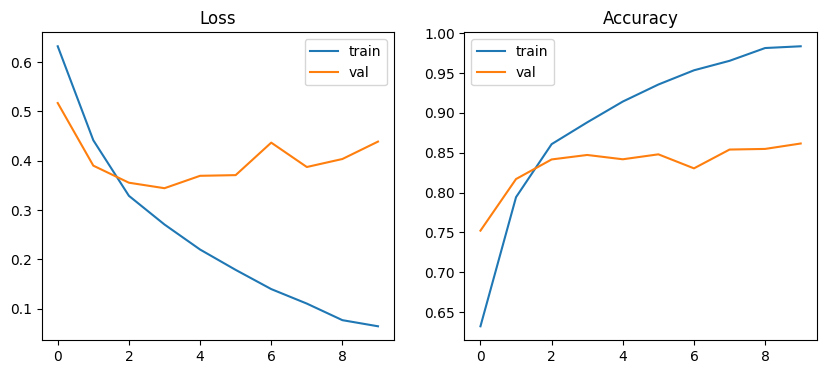

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_steps'], metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_steps'], metrics['val_loss'], label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['train_steps'], metrics['train_accuracy'], label='Train Accuracy')
plt.plot(metrics['val_steps'], metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Sa ovih grafikona možemo primetiti da se posle četvrte epohe model preprilagođava podacima i da ima smisla dodati regularizaciju u vidu `dropout` sloja.

## Korak 4: Evaluacija modela

Mrežu ćemo evaluirati na skupu za testiranje.

In [ ]:
X_test = test_indices_padded
y_test = torch.tensor(test_labels)
model.eval()
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size)

test_loss, test_accuracy, test_samples = 0, 0, 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='test batch', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
    
        batch_size = labels.size(0)
        labels = labels.to(torch.float32)

        predictions = model(inputs).squeeze()
        
        loss = nn.functional.binary_cross_entropy(predictions, labels)
        accuracy = ((predictions > 0.5) == labels).float().mean()
        test_loss += loss.item() * batch_size
        test_accuracy += accuracy.item() * batch_size
        test_samples += batch_size 
test_loss /= test_samples
test_accuracy /= test_samples
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

test batch:   0%|          | 0/3125 [00:00<?, ?it/s]

Test loss: 0.454234882783699
Test accuracy: 0.85344


S obzirom da smo u učenju koristili svega 2000 reči ima smisla probati kako se model ponaša ukoliko se radi sa većim vokabularom. Takođe, ima smisla probati i sa nešto drugačijim ugnježđenim reprezentacijama, na primer, nešto kraćim. Ove zadatke ostavljamo za vežbu.

Možemo još testirati kako se naš model ponaša za novi pregled.

In [ ]:
new_review = "this is the best movie ever"

In [ ]:
word_index = recnik.get_stoi()

In [ ]:
new_review_in_indexes = [word_index[word] for word in new_review.split(' ')]

In [ ]:
new_review_in_indexes

[16, 12, 4, 126, 23, 133]

In [ ]:

new_review_tensor = torch.tensor(new_review_in_indexes)
padding = torch.zeros(max_len - new_review_tensor.shape[0]).to(torch.int32)
padded_sequence = torch.cat([new_review_tensor, padding]).reshape(1, -1)

In [ ]:
padded_sequence.shape

torch.Size([1, 400])

In [ ]:
padded_sequence

tensor([[ 16,  12,   4, 126,  23, 133,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
score = model(padded_sequence.to(device))

In [ ]:
score

tensor([[0.8995]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
new_class = int(score>0.5)

In [ ]:
new_class

1

## Korak 5: Čuvanje modela

Kao i do sada parametre modela ili ceo model možemo čuvati pozivom `torch.save` funkcije.

In [ ]:
torch.save(model.state_dict(), 'saved_models/model_weights.pth')
torch.save(model, 'saved_models/conv1d_model.pth')

model.load_state_dict(torch.load('saved_models/model_weights.pth'))

<All keys matched successfully>

<div class='alert alert-info'>
    Za dalje istraživanje: 
    <a href='https://lena-voita.github.io/nlp_course/models/convolutional.html'> Convolutional Neural Networks for Text </a>
</div>